<a href="https://colab.research.google.com/github/igijon/PyTorch_Fundamentos/blob/main/02_pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be a multiple things as the options).



## 1. Make classification data and get it ready

In [55]:
import sklearn

In [56]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42) # Le damos un poco de ruido para darle un poco de aleatoriedad
len(X), len(y)


(1000, 1000)

In [57]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [58]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X0": X[:, 0],
                        "X1": X[:, 1],
                        "label": y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


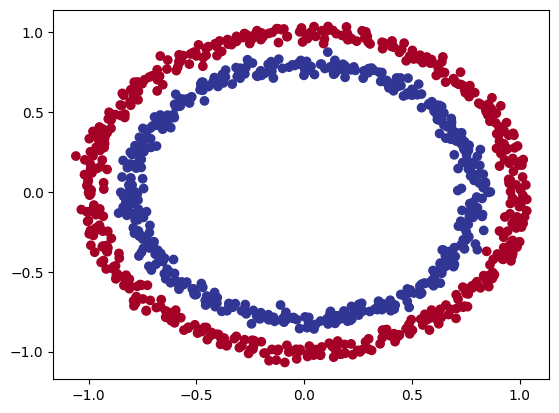

In [59]:
# Visualizando los datos
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
# Con esto vemos que estamos trabajando en clasificación binaria

Note: the data we're working with often referred to as a toy dataset, a dataset that is small enought to experiment but still sizeable enough to practice the fundamentals


https://scikit-learn.org/stable/datasets/toy_dataset.html

### 1.1. Check input and output shapes

In [60]:
X.shape, y.shape

((1000, 2), (1000,))

In [61]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [62]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [63]:
# Turn data into tensors
import torch
torch.__version__

'2.6.0+cu124'

In [64]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [65]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [66]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [67]:
torch.manual_seed(42)

In [68]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 80% training and 20% testing
                                                    random_state=42)

In [69]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [70]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelarator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Defining a loss function and optimizer
4. Create and training and test loop


In [71]:
# Import PyTorch and nn
import torch
from torch import nn

#Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [72]:
X_train, X_train.shape

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         ...,
         [ 0.0157, -1.0300],
         [ 1.0110,  0.1680],
         [ 0.5578, -0.5709]]),
 torch.Size([800, 2]))

 Now we've setup device agnostic code, let's create a model that:

 1. Subclasses `nn.Module` (almost all models in PyTorch are subclasses of `nn.Module`)
 2. Create 2 `nn.Linear()` layuers that are capable of handling the shapes of our data
 3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
 4. Instantiate an instance of our model class and send it to the target `device`


In [73]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shape of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    # Si sólo queremos una capa pondríamos salida 1, pero queremos una intermedia así
    # que por ejemplo ponemos salida 5 y será la entrada de la siguiente capa, este
    # número lo hemos elegido de forma aleatoriaaunque típicamente deben ser múltiplos de 8
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and output a single feature

  # 3. Define a forward method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x->layer_1->layer_2

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [74]:
device

'cpu'

In [75]:
next(model_0.parameters()).device

device(type='cpu')

https://playground.tensorflow.org/


In [76]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [77]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [78]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1. Setup loss function and optimizer

Which loss function should we use?

Again... this is problem specific.

For example, for regression you might want MAE or MSE (mean absolute error or mean squared error).and
For classification, you might want binary cross entropy or category cross entropy.

https://pytorch.org/docs/stable/nn.html#loss-functions

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`
(Logit es una función que mapea probabilidades)
* For different optimnizers see `torch.optim`

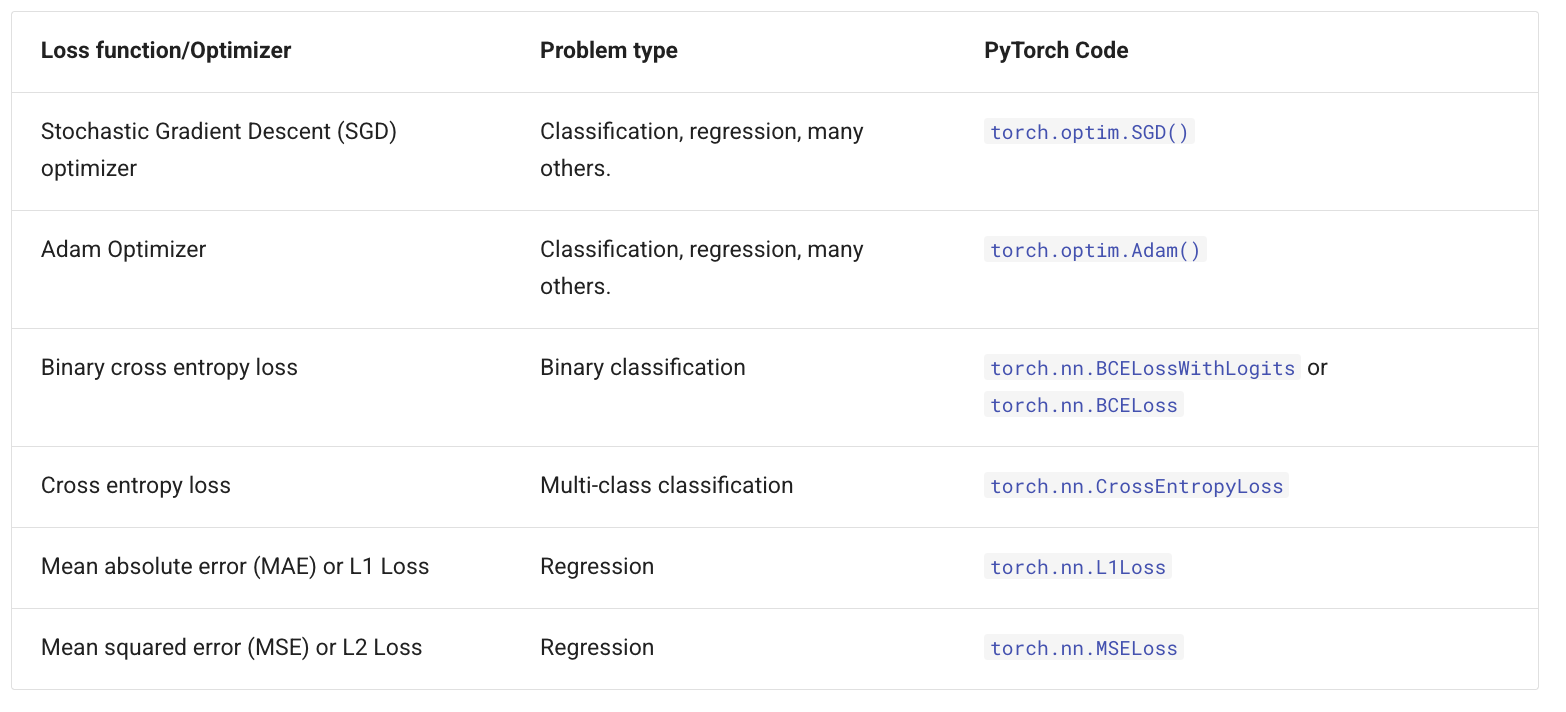

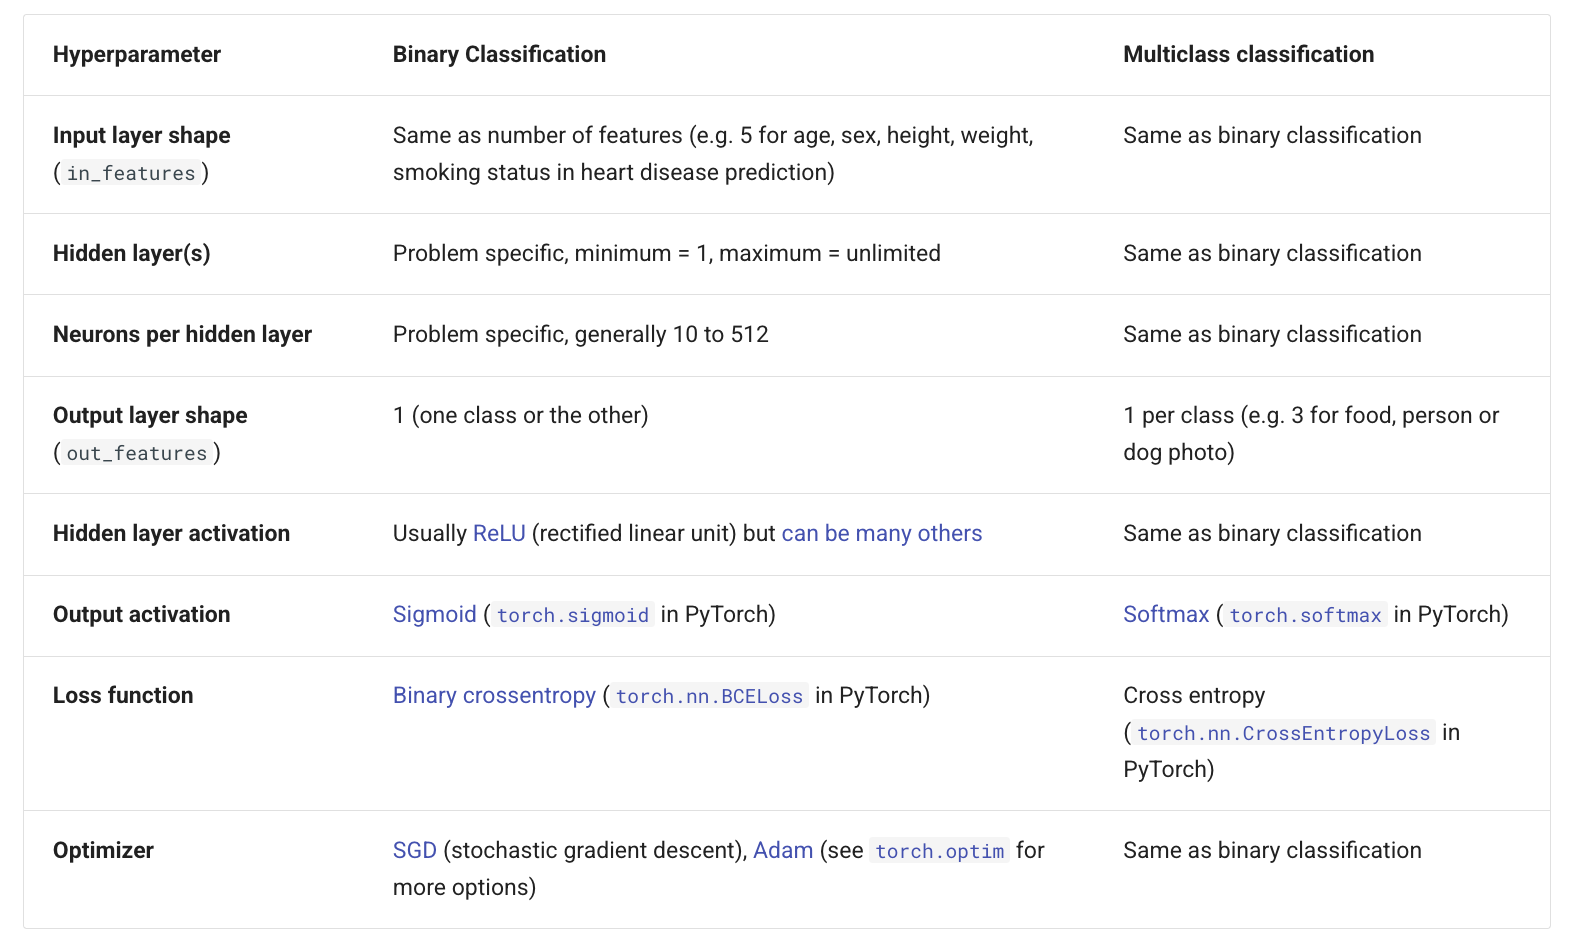

In [79]:
# Setup the loss function
#loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone throgh the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

# Una función de activación, es una función que transmite la información generada por la combinación
# lineal de pesos y las entradas, es decir, son la manera de transmitir la información por las conexiones
# de salida. Normalmente introducen no linealidades, lo que permite a las redes neuronales
# aprender mapeos muy complejos entre entradas y salidas.


# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [80]:
# Calculate accuracy - out of 100 examples, what percentage doew our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)



### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into predictions probabilities by passing them to some kind of activation function(e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking tha `argmax()`

In [81]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode() :
  y_logits = model_0(X_test.to(device))[:5]
y_logits

# Los logits son las salidas brutas de nuestro modelo sin pasar por ninguna función de activación
# Una función de activación es algo un poco separado de una capa

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [82]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [83]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

#Tenemos que utilizar una función de activación sigmoide para convertirlo en probabilidades de predicción

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)


In [84]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred_probs -> pred_labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [85]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2. Building a training and testing loop

In [86]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze() #Aplana
  y_pred = torch.round(torch.sigmoid(y_logits)) #turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  #BCELoss expects prediction probabilities as input
  #loss = loss_fn(torch.sigmoid(y_logits),
  #               y_train)
  loss = loss_fn(y_logits, #BCEWithLogits expects raw logits as input
                 y_train)
  # Esta función (BCEWithLogitsLoss) combina una función de pérdida y una sigmoidea,
  # es más estable numéricamente que BCELoss

  acc = accuracy_fn(y_true=y_train, y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

  #Print out what's happenin'
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")



Epoch: 0 | Loss:  0.69796, Acc: 51.88% | Test loss: 0.69440, Test acc: 58.00
Epoch: 10 | Loss:  0.69590, Acc: 51.25% | Test loss: 0.69305, Test acc: 53.00
Epoch: 20 | Loss:  0.69490, Acc: 51.62% | Test loss: 0.69254, Test acc: 49.50
Epoch: 30 | Loss:  0.69435, Acc: 51.12% | Test loss: 0.69236, Test acc: 49.50
Epoch: 40 | Loss:  0.69401, Acc: 50.88% | Test loss: 0.69232, Test acc: 51.00
Epoch: 50 | Loss:  0.69378, Acc: 50.25% | Test loss: 0.69234, Test acc: 50.00
Epoch: 60 | Loss:  0.69362, Acc: 50.00% | Test loss: 0.69239, Test acc: 51.50
Epoch: 70 | Loss:  0.69351, Acc: 50.25% | Test loss: 0.69246, Test acc: 51.00
Epoch: 80 | Loss:  0.69342, Acc: 49.88% | Test loss: 0.69254, Test acc: 50.00
Epoch: 90 | Loss:  0.69336, Acc: 49.88% | Test loss: 0.69262, Test acc: 53.00


In [87]:
loss_fn

BCEWithLogitsLoss()

In [88]:
loss_fn_without_logits = nn.BCELoss()
loss_fn_without_logits

BCELoss()

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make the visual.

To do so, we're goint to import a function called `plot_decision_boundary()`


In [89]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

  from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


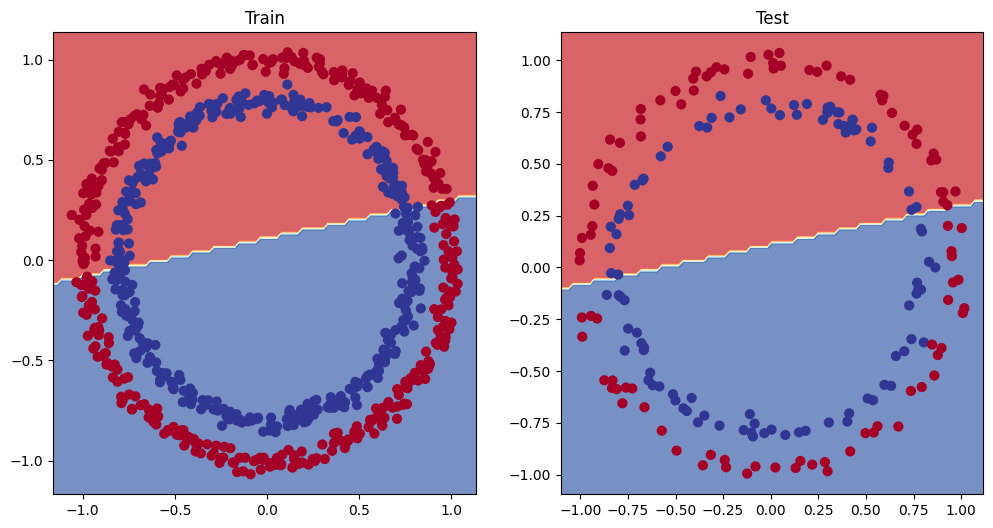

In [90]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate: esto nos ajustará la velocidad a la que el optimizador ajusta... puede que si es demasiado grande no aprenda nada y si es demasiado pequeño el coste computacional sea muy alto.
* Change the loss function.

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [91]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0849, -0.2762],
                      [ 0.4610, -0.5187],
                      [-0.3271, -0.1947],
                      [-0.4220,  0.0507],
                      [-0.7016,  0.6600]])),
             ('0.bias', tensor([-0.6060,  0.5246,  0.1149, -0.2211,  0.4275])),
             ('1.weight',
              tensor([[ 0.0741,  0.2406,  0.0222, -0.1075,  0.1965]])),
             ('1.bias', tensor([-0.1888]))])

In [92]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [93]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [94]:
# Create a loos function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [95]:
# Write a training a testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred_probabilities ->pred_labels

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss:  0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss:  0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss:  0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss:  0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss:  0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss:  0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss:  0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss:  0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss:  0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss:  0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


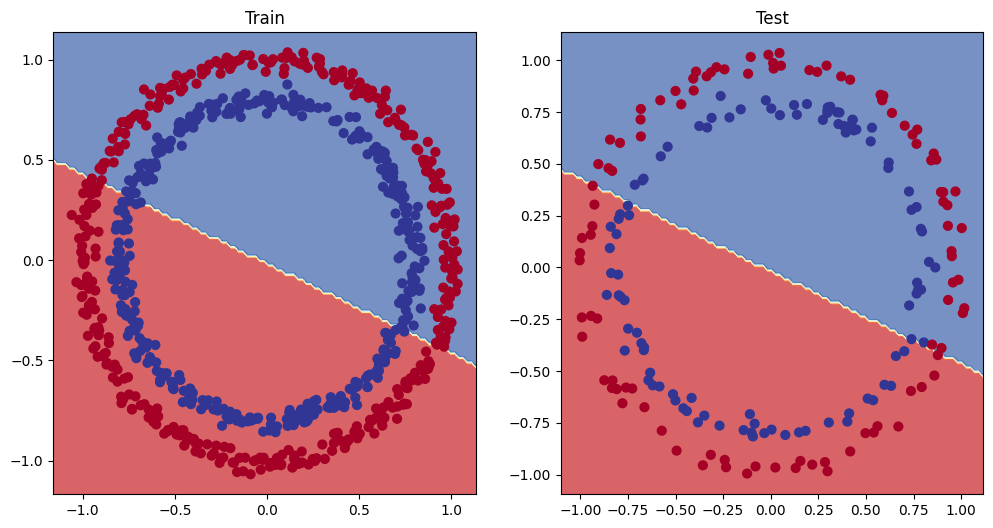

In [96]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 Preparing data to see if our model can fit a straigh line

One way to troubleshoot to a larger problem is to test out a smaller problem.


In [97]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formular (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [98]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

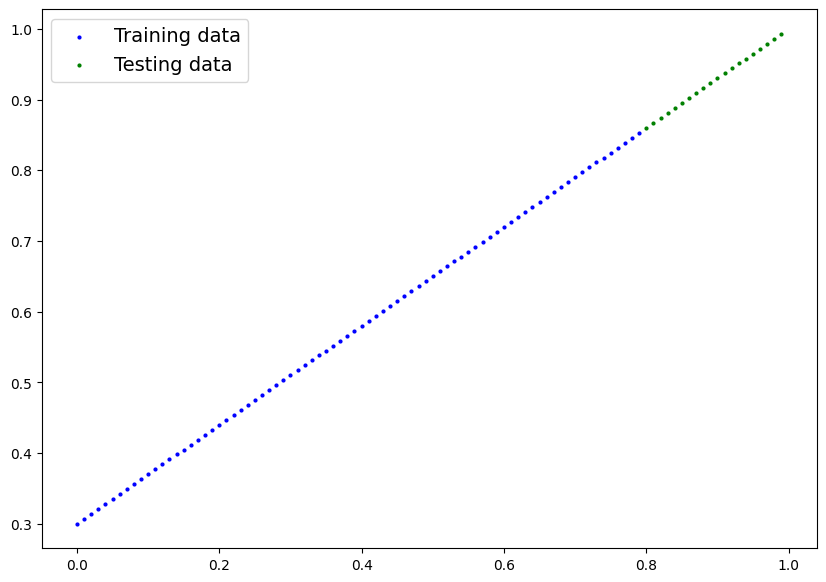

In [99]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [100]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [101]:
X_train_regression[:10], y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

### 5.2 Adjusting `model_1` to fit a straight line



In [102]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [103]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [104]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


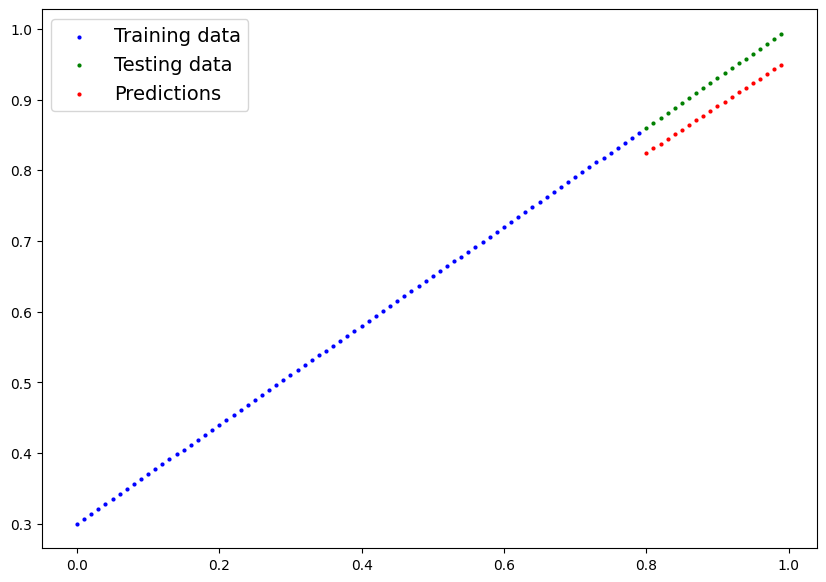

In [105]:
# Turn on evaluation mode
model_2.eval()
# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

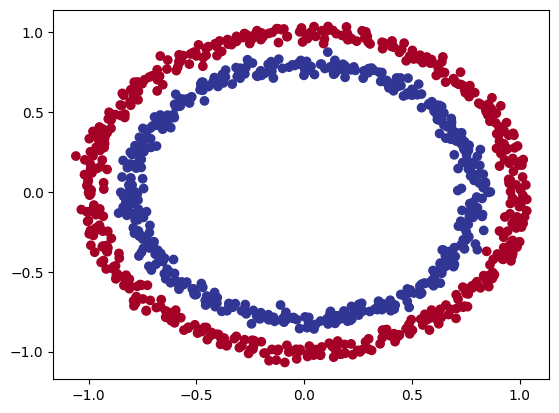

In [106]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [107]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]



(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2. Building a model with non-linearity

* Linear = straight linear
* Non-linear = non-straight lines

https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

Artificial neural networks are a large combination of linear (straight)  and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [108]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # <- add in ReLU activation function (Función lineal rectificada)
    # Relu pone a 0 las negativas y las positivas las deja como está
  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [109]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity



In [112]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits,
                 y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
  # Print out what's this hapenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss:  0.04176, Acc: 99.88% | Test loss: 0.06583, Test acc: 100.00%
Epoch: 100 | Loss:  0.03628, Acc: 99.88% | Test loss: 0.05979, Test acc: 100.00%
Epoch: 200 | Loss:  0.03205, Acc: 99.88% | Test loss: 0.05460, Test acc: 100.00%
Epoch: 300 | Loss:  0.02872, Acc: 99.88% | Test loss: 0.05022, Test acc: 100.00%
Epoch: 400 | Loss:  0.02604, Acc: 99.88% | Test loss: 0.04662, Test acc: 100.00%
Epoch: 500 | Loss:  0.02383, Acc: 99.88% | Test loss: 0.04363, Test acc: 100.00%
Epoch: 600 | Loss:  0.02196, Acc: 99.88% | Test loss: 0.04091, Test acc: 100.00%
Epoch: 700 | Loss:  0.02036, Acc: 99.88% | Test loss: 0.03864, Test acc: 100.00%
Epoch: 800 | Loss:  0.01898, Acc: 99.88% | Test loss: 0.03680, Test acc: 100.00%
Epoch: 900 | Loss:  0.01778, Acc: 99.88% | Test loss: 0.03512, Test acc: 100.00%
